# E-Commerce Retail Analysis on the Highest Selling Item

This notebook analyzes the data gathered from a UK-based online retailer. They primarily sell unique all-occasion gifts to customers, many of which are wholesalers. Data was collected between 1/12/2010 and 9/12/2019 and is stored on an excel file.

We will be investigating Stock Code "85123A", which are small tea-sized candle holders, and exporting an excel file containing this item for further analysis on Tableau.

The data is hosted on UCI's Machine Learning Repository at: https://archive.ics.uci.edu/ml/datasets/online+retail#

# 1. Creating the landscape
## Import libraries

In [8]:
# Math and Data
import numpy as np
import pandas as pd

# Set the output of pandas dataframes to display up to 100 columns
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 100)

# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline

# Misc
from IPython.display import display      # display function prints pandas table instead of text; sub for print()
import copy
import datetime
from tqdm import tqdm

# 2. Exploring the Data
## Check to see if there's any missing data

In [9]:
filepath = 'C:/Users/moogl/Desktop/Python_SQL_Material/Python/Projects/Ecommerce/'

data = pd.read_csv(filepath + 'Online Retail.csv')

print(f'There are {data.shape[0]} rows and {data.shape[1]} columns.')
data.head()

There are 541909 rows and 8 columns.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [10]:
def percent_NA(data):
    """
    Returns a pandas dataframe denoting the total number of NA values and the percentage of NA values in each column.
    The column names are noted on the index.
    
    Parameters
    ----------
    data: dataframe
    """
    # pandas series denoting features and the sum of their null values
    null_sum = data.isnull().sum()

    # instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    # concatenate along the columns to create the complete dataframe
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    # drop rows that don't have any missing data; omit if you want to keep all rows
    df_NA = df_NA[ (df_NA.T != 0).any() ]
    
    return df_NA

NA = percent_NA(data)
NA

,Number of NA,Percent NA
CustomerID,135080,24.93
Description,1454,0.27


## Rank stock codes by sell count

In [11]:
# Ranking using groupby and size
stockcode_cts = data.groupby(by='StockCode').size().sort_values(ascending=False)[:5]

# This is another way to do a groupby using size aggregation
stockcode_cts = data['StockCode'].value_counts().sort_values(ascending=False)
stockcode_cts[:5]

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: StockCode, dtype: int64

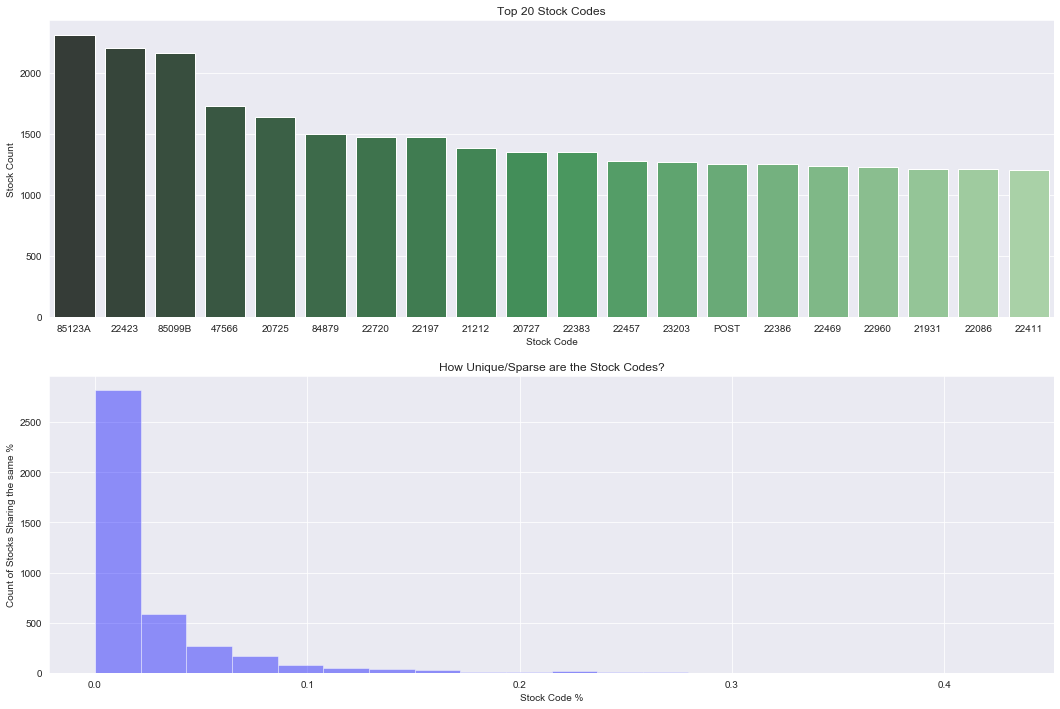

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(18,12))

# Subplot 1
sns.barplot(x=stockcode_cts.iloc[:20].index,
            y=stockcode_cts.iloc[:20].values,
            ax=ax[0], palette='Greens_d')
ax[0].set_xlabel('Stock Code')
ax[0].set_ylabel('Stock Count')
ax[0].set_title('Top 20 Stock Codes')

# Subplot 2
sns.distplot(np.round(stockcode_cts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Blue")
ax[1].set_title("How Unique/Sparse are the Stock Codes?")
ax[1].set_xlabel("Stock Code %")
ax[1].set_ylabel("Count of Stocks Sharing the same %");

The second graph indicates that there is a high volume of stock codes in the data that constitute a small part of all the data. This means that the retailer sells __many different__ products. This may not explain the whole picture. For example, the seller may sell many different types of pencils, each with a different code.

For now, let's look at stock code 85123A which as the most entries in the data with 2313 transactions, so let's look at the time-series for this item.

In [13]:
data[ data['StockCode']=='85123A' ].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 9:02,2.55,17850.0,United Kingdom
66,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 9:32,2.55,17850.0,United Kingdom
220,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,12/1/2010 10:19,2.55,17511.0,United Kingdom
262,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,12/1/2010 10:39,2.55,13408.0,United Kingdom


85123A is described as a white hanging heart t-light holder. This is probably close to what it looks like:

<a href="https://www.fourseasonsliverpool.co.uk/product/tea-light-candle-hanging-heart-t-light-holders-antique-white-metal/"><img src="https://www.fourseasonsliverpool.co.uk/wp-content/uploads/2019/06/127302516.jpeg" style="width: 200px"></a>

# 3. Data Processing
## Change InvoiceDate to a datetime variable

In [14]:
def process_dates(data, col_name):
    data[col_name] = data.index.map(lambda x: data[col_name][x].split()[0])   # x is the columnar object before .map()
    data[col_name] = pd.to_datetime(data[col_name])
    return data
    
data = process_dates(data, 'InvoiceDate')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


## Put T-light data together in a dataframe

In [15]:
tlight_data = data[ data['StockCode']=='85123A' ].reset_index(drop=True)

## Visualize outliers

C:\Users\moogl\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


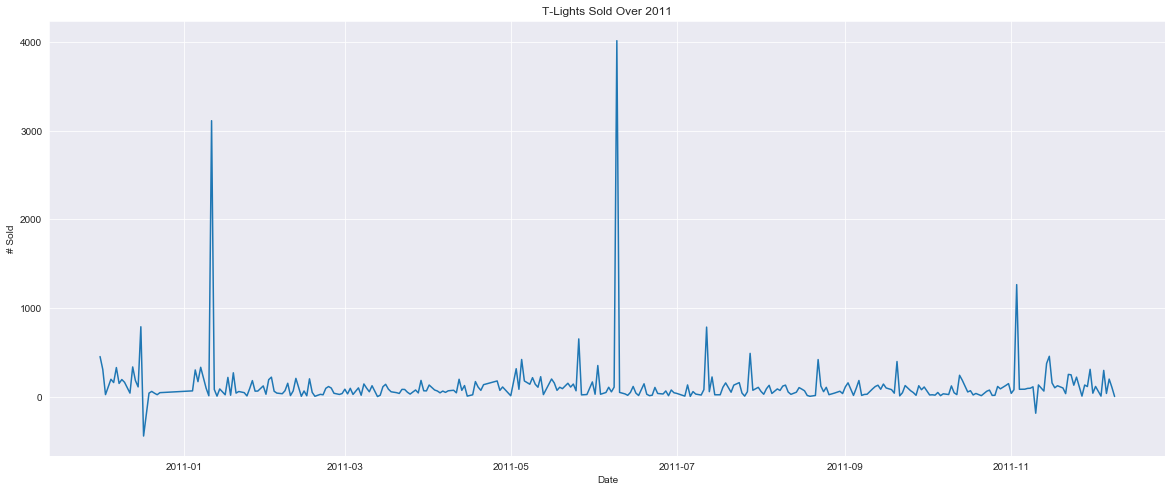

In [16]:
# Group invoice dates together and sum products sold for each date
tlight_quantity = tlight_data.groupby(by='InvoiceDate').sum()['Quantity']

# Plotting
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(tlight_quantity.index, tlight_quantity)
ax.set_xlabel('Date')
ax.set_ylabel('# Sold')
ax.set_title('T-Lights Sold Over 2011');

It seems like we have some huge outliers. We can use Seaborn's boxplot to visualize the outliers:

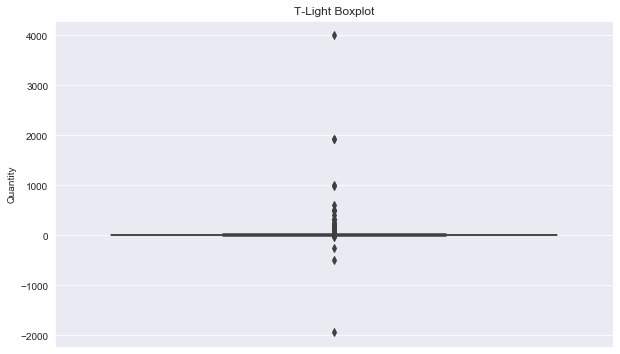

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(tlight_data['Quantity'], orient='v')
plt.title('T-Light Boxplot');

It seems like we have a lot of outliers. To make our investigation more reliable, we'll remove the 5% and 95% percentile from the data and plot the time-series again.

In [18]:
low_quantity = tlight_data['Quantity'].quantile(0.01)
high_quantity = tlight_data['Quantity'].quantile(0.99)

print(f'The 0.01% percentile is: {low_quantity}\nThe 99% percentile is: {high_quantity}')

The 0.01% percentile is: -1.0
The 99% percentile is: 158.8000000000011


In [19]:
# Keep track of the original amount of data
data_ct_before = tlight_data.shape[0]

# Remove outliers
tlight_data = tlight_data.loc[ (tlight_data['Quantity'] >= low_quantity) & (tlight_data['Quantity'] <= high_quantity) ]

# Print the number of data points removed
print(f'The number of outliers removed: {data_ct_before - tlight_data.shape[0]}')

The number of outliers removed: 42


## Visualize without outliers

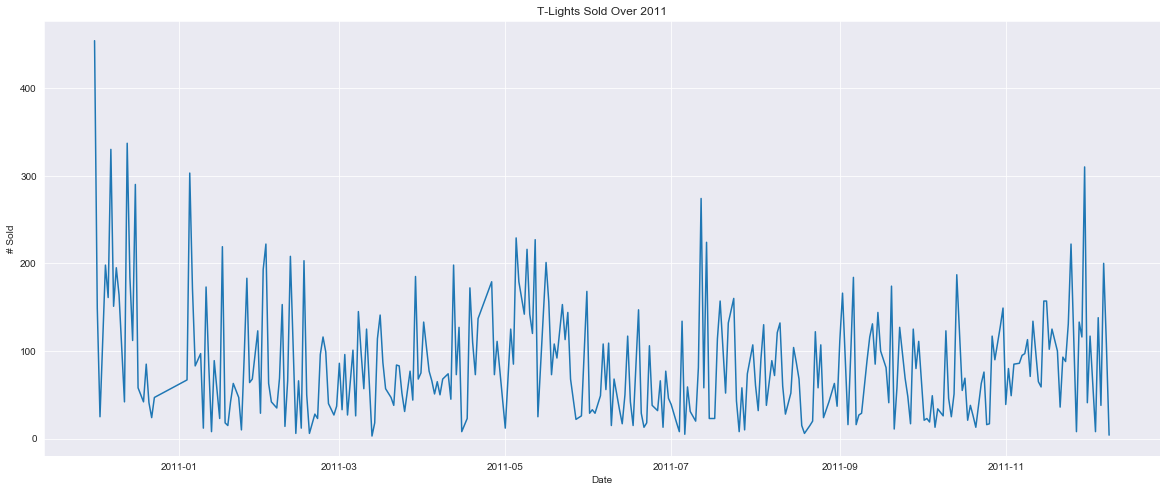

In [33]:
# Group invoice dates together and sum products sold for each date
tlight_quantity = tlight_data.groupby(by='InvoiceDate').sum()['Quantity']

# Plotting
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(tlight_quantity.index, tlight_quantity)
ax.set_xlabel('Date')
ax.set_ylabel('# Sold')
ax.set_title('T-Lights Sold Over 2011');

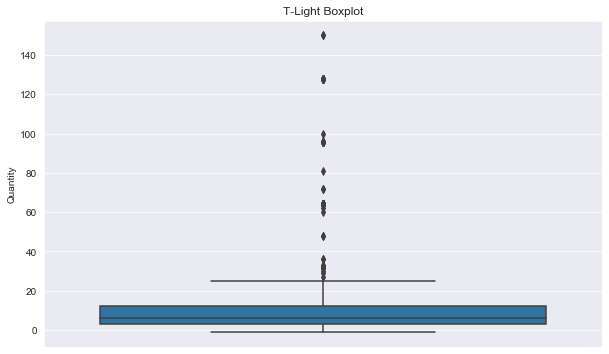

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(tlight_data['Quantity'], orient='v')
plt.title('T-Light Boxplot');

# 4. Export to csv
The csv will contain all orders with the t-light holder and will be analyzed in Tableau

In [41]:
tlight_quantity = pd.DataFrame(tlight_quantity)
tlight_quantity['7 Day MA'] = tlight_quantity.rolling(7).mean()
tlight_quantity.reset_index().to_excel('tlight.xlsx', index=False)

# 5. Visualize on Tableau
Also include 7-day moving average.

To see this visualization, please copy the Github link for this notebook to [Jupyter's nbviewer](https://nbviewer.jupyter.org/)

In [42]:
%%html
<div class='tableauPlaceholder' id='viz1572374770378' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;T-&#47;T-lightsSoldDec2010-Dec2011&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='T-lightsSoldDec2010-Dec2011&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;T-&#47;T-lightsSoldDec2010-Dec2011&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1572374770378');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>